In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn import linear_model, preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn import model_selection
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def df_corr_columns(df, target, threshold):
    df_corr = df.corr()
    df_corr_SalePrice = df_corr[[target]]
    df_corr_SalePrice = df_corr_SalePrice.reset_index()
    df_corr_SalePrice = df_corr_SalePrice[(df_corr_SalePrice['index'] != target)]
    df_corr_SalePrice_columns = df_corr_SalePrice[(
        (df_corr_SalePrice[target] > threshold) | 
        (df_corr_SalePrice[target] < -threshold))]['index']
    return df_corr_SalePrice_columns

In [3]:
def separe_per_unique_threshold(df, threshold):
    dic_c_unique_len = {}
    for c in df.columns:
        dic_c_unique_len[c] = len(df[c].unique())
        #print(c, len(df_num[c].unique()))
 

    df_c_unique_len = pd.DataFrame.from_dict(dic_c_unique_len, orient="index").reset_index()
    df_c_unique_len.columns=['variable', 'count']
    return df_c_unique_len[df_c_unique_len['count'] <= 20].sort_values('count'), df_c_unique_len[df_c_unique_len['count'] > 20].sort_values('count')


In [4]:
def dummies(df, quantiles = 4):
    
    columns = df.columns
    for c in columns:
        
        df[c] = pd.qcut(df[c], q=quantiles, duplicates='drop') # , labels=dummies_cols
        
        df = pd.concat([df, pd.get_dummies(df[c], prefix=c)], axis=1)
        
    df.columns = [c.replace(',', '_') for c in df.columns]
    df.columns = [c.replace('(', '_') for c in df.columns]
    df.columns = [c.replace(']', '_') for c in df.columns]
    df.columns = [c.replace('.', '_') for c in df.columns]
           
        
    df.drop(columns, axis=1, inplace=True)
        
    return df

In [5]:
corr_threshold = 0
dummies_quantiles = 4
variance_threshold = 0.1
unique_values_threshold = 20
pca_components = 0.999


In [6]:
df_train = pd.read_csv("./dataset/train.csv")

df_train_Id = df_train[['Id']]
df_train_SalePrice = df_train[['SalePrice']]
df_train.drop(['Id'], axis=1, inplace=True)
df_train.shape

(1460, 80)

In [7]:
df_test = pd.read_csv("./dataset/test.csv")
df_test_Id = df_test[['Id']]
df_test.drop(['Id'], axis = 1, inplace=True)
df_test.shape

(1459, 79)

In [8]:
df_train = pd.concat([df_train, df_test])
df_train.shape

(2919, 80)

##### Fill the nan

In [9]:
df_train_num =  df_train.select_dtypes(include='number')
df_train_num.fillna(df_train_num.mean(), inplace=True)


df_train_cat = df_train.select_dtypes(include='object')
df_train_cat.fillna(df_train_cat.mode().iloc[0], inplace=True)

df_train = pd.concat([df_train_num, df_train_cat], axis=1)

print(df_train_num.shape, df_train_cat.shape, df_train.shape)

(2919, 37) (2919, 43) (2919, 80)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


### Matrice de correlation

In [10]:
df_train = df_train[df_corr_columns(df_train, 'SalePrice', corr_threshold)]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   LotFrontage    2919 non-null   float64
 2   LotArea        2919 non-null   int64  
 3   OverallQual    2919 non-null   int64  
 4   OverallCond    2919 non-null   int64  
 5   YearBuilt      2919 non-null   int64  
 6   YearRemodAdd   2919 non-null   int64  
 7   MasVnrArea     2919 non-null   float64
 8   BsmtFinSF1     2919 non-null   float64
 9   BsmtFinSF2     2919 non-null   float64
 10  BsmtUnfSF      2919 non-null   float64
 11  TotalBsmtSF    2919 non-null   float64
 12  1stFlrSF       2919 non-null   int64  
 13  2ndFlrSF       2919 non-null   int64  
 14  LowQualFinSF   2919 non-null   int64  
 15  GrLivArea      2919 non-null   int64  
 16  BsmtFullBath   2919 non-null   float64
 17  BsmtHalfBath   2919 non-null   float64
 18  FullBath

In [11]:
df_train_dummies_cols, df_train_scaled_cols = separe_per_unique_threshold(df_train, unique_values_threshold)
print(df_train_dummies_cols.shape, df_train_scaled_cols.shape)

(15, 2) (21, 2)


##### transfert à la main de certaines variables pour discretisation

In [12]:
df_train_dummies_cols = pd.concat([df_train_dummies_cols, df_train_scaled_cols[
    (df_train_scaled_cols['variable'] == 'YearBuilt') |
    (df_train_scaled_cols['variable'] == 'YearRemodAdd') |
    (df_train_scaled_cols['variable'] == 'GarageYrBlt')]])


df_train_scaled_cols = df_train_scaled_cols[
    (df_train_scaled_cols['variable'] != 'YearBuilt') &
    (df_train_scaled_cols['variable'] != 'YearRemodAdd') &
    (df_train_scaled_cols['variable'] != 'GarageYrBlt')]



In [13]:
df_train_dummies_cols

,variable,count
19,HalfBath,3
17,BsmtHalfBath,4
21,KitchenAbvGr,4
16,BsmtFullBath,5
18,FullBath,5
23,Fireplaces,5
35,YrSold,5
25,GarageCars,7
20,BedroomAbvGr,8
4,OverallCond,9


In [14]:
df_train_scaled_cols

,variable,count
30,3SsnPorch,31
14,LowQualFinSF,36
33,MiscVal,38
31,ScreenPorch,121
1,LotFrontage,129
29,EnclosedPorch,183
28,OpenPorchSF,252
9,BsmtFinSF2,273
27,WoodDeckSF,379
7,MasVnrArea,445


### Dummies

In [15]:
df_train_dummies = dummies(df_train[df_train_dummies_cols['variable'].tolist()])

df_train_dummies.head()

<ipython-input-4-8fc706ab67e0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = pd.qcut(df[c], q=quantiles, duplicates='drop') # , labels=dummies_cols


,HalfBath__-0_001_ 1_0_,HalfBath__1_0_ 2_0_,BsmtHalfBath__-0_001_ 2_0_,KitchenAbvGr__-0_001_ 1_0_,KitchenAbvGr__1_0_ 3_0_,BsmtFullBath__-0_001_ 1_0_,BsmtFullBath__1_0_ 3_0_,FullBath__-0_001_ 1_0_,FullBath__1_0_ 2_0_,FullBath__2_0_ 4_0_,...,YearRemodAdd__1993_0_ 2004_0_,YearRemodAdd__2004_0_ 2010_0_,GarageYrBlt__1894_999_ 1961_5_,GarageYrBlt__1961_5_ 1978_113_,GarageYrBlt__1978_113_ 2001_0_,GarageYrBlt__2001_0_ 2207_0_,YearBuilt__1871_999_ 1953_5_,YearBuilt__1953_5_ 1973_0_,YearBuilt__1973_0_ 2001_0_,YearBuilt__2001_0_ 2010_0_
0,1,0,1,1,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
1,1,0,1,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,1,0,1,1,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
3,1,0,1,1,0,1,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
4,1,0,1,1,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


### Scaled

In [16]:
df_train_scaled = df_train[df_train_scaled_cols['variable'].tolist()]

scaler = preprocessing.StandardScaler().fit(df_train_scaled)
df_train_scaled[df_train_scaled.columns] = pd.DataFrame(scaler.transform(df_train_scaled), index=df_train_scaled.index)

df_train_scaled.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,3SsnPorch,LowQualFinSF,MiscVal,ScreenPorch,LotFrontage,EnclosedPorch,OpenPorchSF,BsmtFinSF2,WoodDeckSF,MasVnrArea,GarageArea,2ndFlrSF,BsmtFinSF1,TotalBsmtSF,1stFlrSF,BsmtUnfSF,GrLivArea,LotArea
0,-0.103331,-0.101197,-0.089592,-0.285935,-0.202068,-0.359601,0.200006,-0.29313,-0.740760,0.525202,0.348900,1.207379,0.580907,-0.444328,-0.773861,-0.934863,0.413547,-0.217879
1,-0.103331,-0.101197,-0.089592,-0.285935,0.501870,-0.359601,-0.702843,-0.29313,1.614879,-0.572250,-0.059792,-0.785025,1.178112,0.477111,0.261075,-0.629896,-0.471891,-0.072044
2,-0.103331,-0.101197,-0.089592,-0.285935,-0.061280,-0.359601,-0.081209,-0.29313,-0.740760,0.334828,0.627553,1.235375,0.097873,-0.299076,-0.610718,-0.288516,0.563755,0.137197
3,-0.103331,-0.101197,-0.089592,-0.285935,-0.436714,3.874967,-0.184815,-0.29313,-0.740760,-0.572250,0.785457,0.978742,-0.494941,-0.671283,-0.506205,-0.047275,0.427382,-0.078385
4,-0.103331,-0.101197,-0.089592,-0.285935,0.689587,-0.359601,0.540424,-0.29313,0.776967,1.387486,1.686437,1.671651,0.468931,0.211573,-0.037170,-0.161068,1.378042,0.518903


In [17]:
df_train = pd.concat([df_train_dummies, df_train_scaled], axis=1)
df_train.shape

(2919, 71)

##### variance filter

In [18]:
'''
selector = VarianceThreshold(variance_threshold)

selector.fit(df_train)
features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
#features
features = [column for column in df_train.columns[features]] #Array of all nonremoved features' names
#features
#Format and Return
df_train = pd.DataFrame(selector.transform(df_train))
df_train.columns = features
'''

"\nselector = VarianceThreshold(variance_threshold)\n\nselector.fit(df_train)\nfeatures = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features\n#features\nfeatures = [column for column in df_train.columns[features]] #Array of all nonremoved features' names\n#features\n#Format and Return\ndf_train = pd.DataFrame(selector.transform(df_train))\ndf_train.columns = features\n"

##### separate train - test

In [19]:
df_test = df_train.tail(1459) 
df_train = df_train.head(1460) 

print(df_train.shape, df_test.shape)

(1460, 71) (1459, 71)


In [20]:
target = df_train_SalePrice
data = df_train

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.3, random_state = 66) 

##### pca reduction dimension

In [21]:
'''
print(X_train.shape, X_test.shape)
pca = PCA(n_components = pca_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape, X_test.shape)
'''

'\nprint(X_train.shape, X_test.shape)\npca = PCA(n_components = pca_components)\nX_train = pca.fit_transform(X_train)\nX_test = pca.transform(X_test)\nprint(X_train.shape, X_test.shape)\n'

In [22]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
print(xgboost.__version__)

1.5.2


### XGBRegressor

https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
    
https://stackoverflow.com/questions/53731529/using-xgboost-regressor-in-python-results-in-very-good-training-performance-but

In [23]:
# create an xgboost regression model
#model_xgbr = XGBRegressor()

# Instantiation
xgb_r = XGBRegressor(objective ='reg:squarederror', learning_rate=0.3, subsample=1, colsample_bytree=1, gamma=0.1,
                     max_depth=4, 
                  n_estimators = 50, seed = 123)
  
# Fitting the model
eval_set = [(X_test, y_test)]
xgb_r.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)
  
# Predict the model
pred = xgb_r.predict(X_test)
  
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

[0]	validation_0-rmse:140531.98438
[1]	validation_0-rmse:102428.70312
[2]	validation_0-rmse:76651.45312
[3]	validation_0-rmse:58657.68750
[4]	validation_0-rmse:46432.23047
[5]	validation_0-rmse:38799.63281
[6]	validation_0-rmse:34225.07422
[7]	validation_0-rmse:31346.15625
[8]	validation_0-rmse:29994.58398
[9]	validation_0-rmse:29065.33008
[10]	validation_0-rmse:28821.69531
[11]	validation_0-rmse:28328.34766
[12]	validation_0-rmse:28063.97656
[13]	validation_0-rmse:27732.77930
[14]	validation_0-rmse:27568.25000
[15]	validation_0-rmse:27338.38477
[16]	validation_0-rmse:27274.88672
[17]	validation_0-rmse:27145.64062
[18]	validation_0-rmse:27111.34570
[19]	validation_0-rmse:27210.49414
[20]	validation_0-rmse:27229.26953
[21]	validation_0-rmse:27137.46094
[22]	validation_0-rmse:27087.14648
[23]	validation_0-rmse:27148.98438
[24]	validation_0-rmse:27102.09180
[25]	validation_0-rmse:27058.30469
[26]	validation_0-rmse:27082.51172
[27]	validation_0-rmse:27143.42969
[28]	validation_0-rmse:27134

In [24]:
print("score train :",xgb_r.score(X_train, y_train))
print("score test :", xgb_r.score(X_test, y_test))

score train : 0.9850213117920847
score test : 0.8851263364494057


In [25]:
#pred = xgb_r.predict(pca.transform(df_test))
pred = xgb_r.predict(df_test)

df_pred = pd.DataFrame(pred, columns=['SalePrice'])
df_pred.head()

,SalePrice
0,128231.750000
1,182711.187500
2,177454.281250
3,187708.703125
4,192396.328125


In [26]:
df_pred = df_test_Id.join(df_pred)

df_pred.shape

(1459, 2)

In [27]:
df_pred.to_csv('./submission/model_xgb_r.csv', index=False)

### GradientBoostingRegressor

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

In [69]:
gbrt = GradientBoostingRegressor(max_depth=4, n_estimators = 5000, learning_rate=0.1, verbose=True)

In [70]:
gbrt.fit(X_train, y_train.values.ravel())

      Iter       Train Loss   Remaining Time 
         1  5360109808.4857            1.08m
         2  4562394014.1364           45.86s
         3  3908596329.2408           30.56s
         4  3337834812.4866           40.08s
         5  2867610005.2076           32.06s
         6  2490308773.2306           37.54s
         7  2162586481.8787           34.13s
         8  1897706783.4305           33.30s
         9  1680527085.1986           34.06s
        10  1487605398.7208           34.64s
        20   576742060.0333           31.01s
        30   335284388.6090           30.99s
        40   248863599.8871           31.16s
        50   208409664.0842           29.52s
        60   180585233.2645           29.70s
        70   160832925.0635           30.91s
        80   146137742.8529           30.95s
        90   130930059.3320           30.87s
       100   118972617.1688           30.02s
       200    50959533.6163           29.93s
       300    23394502.5739           29.13s
       40

GradientBoostingRegressor(max_depth=4, n_estimators=5000, verbose=True)

In [71]:
pred = gbrt.predict(X_test)

In [72]:
gbrt.score(X_test, y_test)

0.864357683384419

In [73]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  29138.450167


In [34]:
df_pred.to_csv('./submission/model_gbrt.csv', index=False)

##### tests

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

###### learning_rates

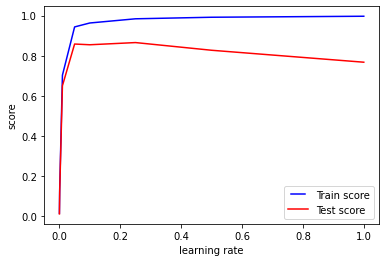

In [55]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001, 0.0001]
train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingRegressor(learning_rate=eta)
   model.fit(X_train, y_train.values.ravel())
   train_pred = model.predict(X_train)
   train_results.append(model.score(X_train, y_train.values.ravel()))
   y_pred = model.predict(X_test)
   test_results.append(model.score(X_test, y_test))
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train score")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("score")
plt.xlabel("learning rate")
plt.show()

###### n_estimators

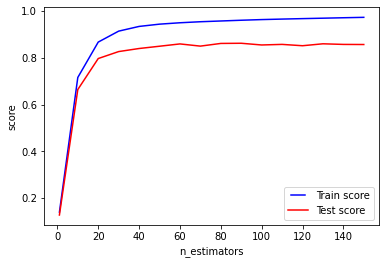

In [56]:
n_estimators = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
train_results = []
test_results = []
for eta in n_estimators:
   model = GradientBoostingRegressor(n_estimators=eta)
   model.fit(X_train, y_train.values.ravel())
   train_pred = model.predict(X_train)
   train_results.append(model.score(X_train, y_train.values.ravel()))
   y_pred = model.predict(X_test)
   test_results.append(model.score(X_test, y_test))
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train score")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.show()